In [1]:
%matplotlib notebook
import sys
import os
import numpy as np
import pandas as pd
from Klujn_2015_FootprinModel.calc_footprint_FFP_climatology_SkeeterEdits import FFP_climatology

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape

import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt
# import matplotlib
from geopandas import GeoDataFrame

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


from functools import partial
from multiprocessing import Pool
import time

In [3]:
Data = pd.read_csv('Quick_Data.csv',parse_dates={'Datetime':[0]})
Data = Data.set_index(pd.DatetimeIndex(Data.Datetime))
Data['Run']=0
Axis = 35
Data.loc[(Data['u*']>.1)& ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),['Run']]=1
Dates = Data['Datetime']

FileNotFoundError: File b'Quick_Data.csv' does not exist

<generator object <genexpr> at 0x0000013AD560CEB8>


<IPython.core.display.Javascript object>


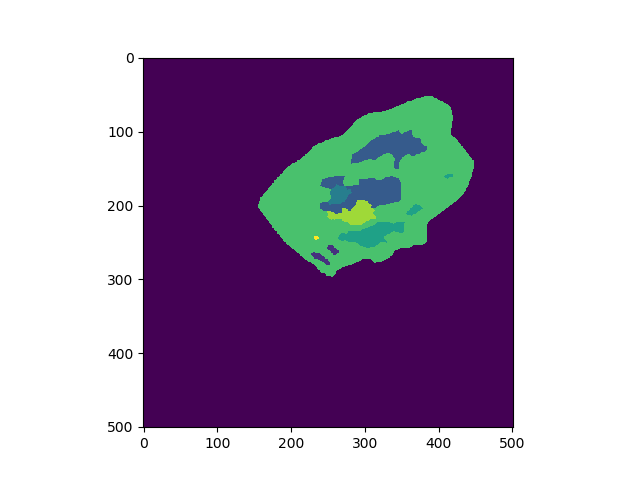

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 501, 'height': 501, 'count': 1, 'crs': CRS({}), 'transform': (515597.33, 2.0, 0.0, 7708431.12, 0.0, -2.0), 'affine': Affine(2.0, 0.0, 515597.33,
       0.0, -2.0, 7708431.12), 'tiled': False, 'interleave': 'band'}


In [9]:
def Intersection(FP,Image,Basin,Data,i,dx):
    fpf = np.flipud(FP['fclim_2d'])*dx**2
    fpf/=fpf.sum()
    for c,C in zip(Basin['Code'],Basin['Name']): 
#         print(c,C)
        WP = Image+0.0 
        WP[WP != c]=0
        WP[WP == c]=1
        WP = WP * fpf
        Data[C].loc[i]+=WP.sum()
    TP = Image + 0.0
    TP[TP >0] = 1
    TP = TP * fpf
    Data['BasinTotal'].loc[i] = TP.sum()
    Data['OutOfBasin'].loc[i] = 1-TP.sum()
    return(Data,fpf)

def RunFunc(i,Dates,Data,Image,Basin,fp_params):
    if Data['Run'].loc[Dates[i]]==1:
        FP = cffc.FFP_climatology(zm=[Data['Zm'].loc[Dates[i]]],z0=[Data['Zo'].loc[Dates[i]]],
                                  h=[Data['Zi'].loc[Dates[i]]],ol=[Data['L'].loc[Dates[i]]],
                                  sigmav=[Data['v_var'].loc[Dates[i]]],ustar=[Data['ustar'].loc[Dates[i]]],
                                  wind_dir=[Data['wind_dir'].loc[Dates[i]]]
                ,**fp_params)
        Data,fpf = Intersection(FP,Image,Basin,Data,Dates[i],fp_params['dx'])
        return(Data.loc[Dates[i]],fpf)
    return('Error')


Time = time.time()
rs = [50,75,90]
dx = 2
# XY = [516099.0,7707928.0]
XY = [516097.33,7707931.12]
nx = 500 
fp_params=[dx,nx,rs]
fp_params={'dx':dx,'nx':nx,'rs':rs}
Basin = gpd.read_file('C:/Illisarvik/Vegetation1.0.shp')
Basin['Area'] = Basin.area
Basin['Dkey'] = 1
BasinBounds = Basin.dissolve(by='Dkey').geometry[1]   
# for c in Basin['Name']:  
#     Data[c] = 0.0
# Data['BasinTotal'] = 0.0
# Data['OutOfBasin'] = 0.0
# Data['Contour_Check_70'] = 0.0
# # Data['Contour_Check_80'] = 0.0
# Data['Contour_Check_90'] = 0.0

shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin['Code']))
print(shapes)

west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)

plt.figure()

with rasterio.open('temp.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.transform,default_value=0)

    plt.imshow(Image)
print(params)
# os.remove('temp.tif')
# if __name__ == '__main__':  
#     processes=8
#     pool = Pool(processes=processes,maxtasksperchild=50)
#     Results = []
#     Climatology = np.zeros(shape=(nx+1,nx+1))
#     for res in enumerate(pool.imap(partial(RunFunc,Dates=Dates,Data=Data,Image=Image,Basin=Basin,
#                                           fp_params=fp_params),range(Data.shape[0]))):
#         print(Dates[res[0]])
#         if res[1]!='Error':
#             Climatology += res[1][1]
#             Data.loc[Dates[res[0]]]=res[1][0]
#             print()
#         else:
            
#             print('Error')
#     pool.close()
# Climatology/=res[0]
# plt.imshow(Climatology,alpha = .5,cmap='gray')
# plt.xlim(2/5*nx,3/5*nx)
# plt.ylim(3/5*nx,2/5*nx)
# plt.colorbar()
# print(time.time()-Time)
# Data.to_csv('UpdateFootprints.csv')

<IPython.core.display.Javascript object>


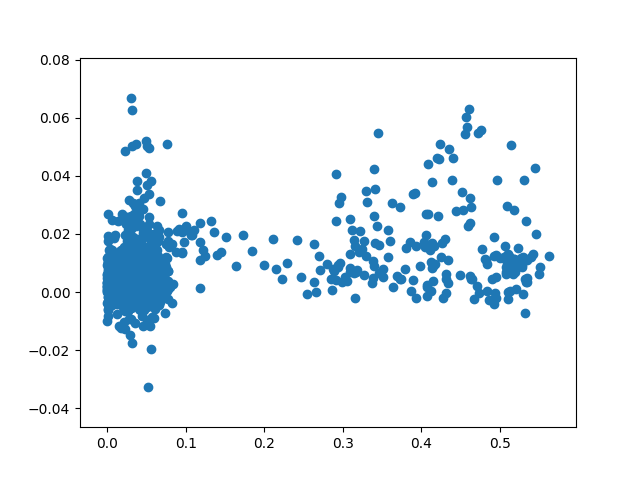

0.0974028212309


In [63]:
plt.figure()
plt.scatter(Data['Sedge'],Data['ch4_flux'])
print(Data['Sedge'].mean())
    

In [17]:
class Process:
    def __init__(self,XY,dx,rs,nx,path):
        ##Read and Filter
        self.path = path
        Unfiltered = pd.read_csv('C:/Illisarvik/TestData.csv',parse_dates={'Datetime':[0]})
        Unfiltered = Unfiltered.set_index(pd.DatetimeIndex(Unfiltered.Datetime))
        self.Data = Unfiltered[(Unfiltered['ustar']>.1)& ((Unfiltered['wind_dir']<190)|(Unfiltered['wind_dir']>250))]# & (|(Unfiltered['wind_dir']<0.35))]
        ##Dimmensions
        self.dx,self.XY,self.nx = dx,XY,nx
#         self.XY = XY
#         self.nx = nx
        ##Basin.shp import   
        self.Basin = gpd.read_file('C:/Illisarvik/Vegetation1.0.shp')#C:/Users/wesle/Dropbox/GisData/VegSurvey_Split.shp
        self.Basin['Area'] = self.Basin.area
        self.Basin['Dkey'] = 1
        self.BasinBounds = self.Basin.dissolve(by='Dkey').geometry[1]       
        ##Add Classes to Data
        for c in self.Basin['Name']:  
            print(c)
            self.Data[c] = 0.0
        self.Data['BasinTotal'] = 0.0
        self.Data['OutOfBasin'] = 0.0
        self.Data['Contour_Check_70'] = 0.0
        self.Data['Contour_Check_80'] = 0.0
        self.Data['Contour_Check_90'] = 0.0
        self.Basin_Image()
        self.Run()
        
    def Basin_Image(self):
        shapes = ((geom,value) for geom,value in zip(self.Basin['geometry'],self.Basin['Code']))
        west = self.XY[0]-(self.nx*self.dx)/2
        north = self.XY[1]+(self.nx*self.dx)/2
        self.Transform = from_origin(west,north,self.dx,self.dx)
        with rasterio.open('temp.tif','w',driver='GTiff',width = self.nx+1, height = self.nx+1,count = 1,dtype=np.float64,
                           affine = self.Transform,crs = ({'init': 'EPSG:32608'})) as out:
            out_arr = out.read(1)
            self.params = out.profile
            self.Burned = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.transform,default_value=0)

            plt.imshow(self.Burned)
            
    def Run(self):
        for x in self.Data.index:
            self.x = x
            print ('')
            print (self.Data['Datetime'][x])
            print ('')
            if self.Data['L'][x] != np.nan:
                self.FP = cffc.FFP_climatology(zm=[self.Data['Zm'][x]],z0=[self.Data['Zo'][x]],h=[self.Data['Zi'][x]]
                ,ol=[self.Data['L'][x]],sigmav=[self.Data['v_var'][x]],ustar=[self.Data['ustar'][x]],wind_dir=[self.Data['wind_dir'][x]]
                ,dx=self.dx,nx=self.nx,rs=rs)
    #            self.fpf = np.flipud(self.FP['fclim_2d'])   
#                 if self.FP['flag_err'] == 0 and self.FP['rr']!=[0]:
                self.Spatial()
# #                 else:
# #                     print ('error: ',self.Data[self.Data.index == x])
#         Filter = 150
#         Name = 'ADir'
        
#         self.ClimWrite(self.Data,'11_14')
        
#        D = self.Data#[(self.Data[Name]==-95.0)]
#        self.ClimWrite(D,'Test')
        
#        D = self.Data[self.Data[Name]>=150]
#        self.ClimWrite(D,'Day')
#        D = self.Data[self.Data[Name]<150]
#        self.ClimWrite(D,'Night')
#        
#        Filter = datetime(2016,7,23,0,0)
#        D = self.Data[self.Data.index<Filter]
#        self.ClimWrite(D,'Pre_205')
#        D = self.Data[self.Data.index>=Filter]
#        self.ClimWrite(D,'Post_205')
                
    def Polygen(self,X,Y,XY,Poly=None):  
        if Poly == None:
            Poly = np.transpose(np.squeeze([np.asanyarray(X),np.asanyarray(Y)]))+XY    
        else:
            Poly = np.append(Poly,np.transpose(np.squeeze([np.asanyarray(X),np.asanyarray(Y)]))+XY,axis = 0)
        return(Poly)
    
    def DFGen(self,i,d,idx,df=None):   ##### Need to change Index to datetime?  or some kind of identifier.
        if i == 0 and idx ==1:
            df = pd.DataFrame(data=d,index=[idx])
        else:
            df2 = pd.DataFrame(data=d,index=[idx])
            df = pd.concat([df,df2])
        return (df)
    
    def ClimWrite(self,D,Name):
        FP = cffc.FFP_climatology(zm=D['Zm'].values,z0=D['Zo'].values,h=D['Zi'].values,ol=D['L'].values
        ,sigmav=D['v_var'].values,ustar=D['ustar'].values,wind_dir=D['wind_dir'].values
        ,dx=self.dx,nx=self.nx,rs=rs)
        with rasterio.open('C:/Illisarvik/Footprints/Rasters/Climatology'+Name+'.tif','w',
                           driver='GTiff',width = self.nx+1, height = self.nx+1,count = 1,dtype=np.float64,
                           affine = self.Transform,crs = ({'init': 'EPSG:32608'})) as Writer:
            Dat = np.flipud(FP['fclim_2d']*self.dx**2)
            Writer.write(Dat,1)
#        FP['rs'],FP['xr'],FP['FP['yr']']
        index = np.arange(0,len(FP['rs']))
        geometry = list()
        idx = -1
        index = np.arange(0,len(rs))
        if geometry == None: geometry = list()
        idx = -1
        df = None
        for i in index:  
            idx+=1
            i2 = 0
            parts = len(FP['xr'][i])
            d = {'r':rs[i]}#,'MO':datetime.month,'DY':datetime.day,'HR':datetime.hour,'MN':datetime.minute,'Dir':wind_dir}
            if parts !=1:
                for i2 in range(0,parts):
                    Poly = self.Polygen(FP['xr'][i][i2],FP['yr'][i][i2],self.XY)
                    idx+=1
                    if i2 == 0:
                        P = Polygon(Poly)
                        geometry.append(P)
                        df = self.DFGen(i,d,idx,df)
#                         print (df)
                    else:
                        P2 = Polygon(Poly)
                        if P.intersects(P2) == True:                    ## Check if Interior Ring!!
                            idx-=1
                            geometry.remove(P)
                            P = P.symmetric_difference(P2)
                            geometry.append(P)
                        else:
                            geometry.append(P2)
                            df = self.DFGen(i,d,idx,df)
#                             print (df)
            else:
                Poly = self.Polygen(FP['xr'][i][0],FP['yr'][i][0],XY)
                d = {'r':rs[i]}
                geometry.append(Polygon(Poly))
                df = self.DFGen(i,d,idx,df)
        geo_df = GeoDataFrame(df,crs={'init': 'EPSG:32608'},geometry = geometry)
        geo_df['coutour'] = geo_df['r']
            
        geo_df = geo_df.dissolve(by = 'r')
        geo_df['area'] =  geo_df.area 
#         print(geo_df)
        geo_df.to_file('C:/Illisarvik/Footprints/Rasters/Climatology_rs'+Name+'.shp', driver = 'ESRI Shapefile')
            
    def Spatial(self):
        print('poop')
        self.fpf = np.flipud(self.FP['fclim_2d'])*self.dx**2
        dt = self.Data['Datetime'][self.x]
        Name = str(dt.minute + dt.hour*100 + dt.day*10000+dt.month*1000000)
        with rasterio.open('C:/Illisarvik/Footprints/Rasters/'+Name+'.tif','w',
                           driver='GTiff',width = self.nx+1, height = self.nx+1,count = 1,dtype=np.float64,
                           affine = self.Transform,crs = ({'init': 'EPSG:32608'})) as Writer:
            Writer.write(self.fpf,1)
#         print(self.FP['xr'][3],self.FP['yr'][3])
        
        Poly50 = Polygon(np.transpose(np.squeeze([np.asanyarray(self.FP['xr'][1][0]),np.asanyarray(self.FP['yr'][1][0])]))+self.XY)
        Poly70 = Polygon(np.transpose(np.squeeze([np.asanyarray(self.FP['xr'][1][0]),np.asanyarray(self.FP['yr'][1][0])]))+self.XY)
        Poly80 = Polygon(np.transpose(np.squeeze([np.asanyarray(self.FP['xr'][2][0]),np.asanyarray(self.FP['yr'][2][0])]))+self.XY)
#         Poly90 = Polygon(np.transpose(np.squeeze([np.asanyarray(self.FP['xr'][3][0]),np.asanyarray(self.FP['yr'][3][0])]))+self.XY)
        
        data = rs
        
        d=['A','B','C','D']
        df = pd.DataFrame(data=data,index=d,columns=['coutour'])
        geom = []
    
    
#         geom.append(Poly50)
#         geom.append(Poly70)
#         geom.append(Poly80)
# #         geom.append(Poly90)
#         geodf = GeoDataFrame(df,crs={'init': 'EPSG:32608'},geometry = geom)
#         geodf['area'] =  geodf.area 
#         geodf.to_file('C:/Illisarvik/Footprints/Rasters/'+Name+'_rs.shp', driver = 'ESRI Shapefile')
        
#         if Poly70.within(self.BasinBounds) == True:
#             self.Data['Contour_Check_70'][self.x]=1
#         if Poly80.within(self.BasinBounds) == True:
#             self.Data['Contour_Check_80'][self.x]=1
#         if Poly90.within(self.BasinBounds) == True:
#             self.Data['Contour_Check_90'][self.x]=1
        for c,C in zip(self.Basin['Code'],self.Basin['Name']): 
            WP = self.Burned+0.0 
            WP[WP != c]=0
            WP[WP == c]=1
            WP = WP * self.fpf
            self.Data[C][self.x]+=WP.sum()
        TP = self.Burned + 0.0
        TP[TP >0] = 1
        TP = TP * self.fpf
        self.Data['BasinTotal'][self.x] = TP.sum()
        self.Data['OutOfBasin'][self.x] = 1-TP.sum()
        #dx = 10
#rs = [25,50,60,70,75,80,90]
rs = [50,70,80,90]
dx = 10
XY = [516099.0,7707928.0]
XY = [516097.33,7707931.12]
nx = 100
path = root+'/Illisarvik/'
Run = Process(XY,dx,rs,nx,path)

print(Run.Data['Sedge'])
write = 'Y'

FileNotFoundError: File b'C:/Illisarvik/TestData.csv' does not exist

In [ ]:
print(Run.Data['Sedge'])